## Ingénierie des caractéristiques I (10%)

In [4]:
import numpy as np
import pandas as pd
from plots import * # tous les plus utilisés

In [ ]:
# Nettoyage des données

def clean_data(path) :
    """
    Nettoie un DataFrame de données de jeu NHL à partir d'un fichier JSON.

    Args:
        path (str): Le chemin vers le fichier JSON contenant les données de jeu NHL.

    Returns:
        pd.DataFrame: Un DataFrame propre contenant les colonnes 'emptyNet', 'isGoal',
                     'x', 'y', 'distanceToNet', et 'relativeAngleToNet'.

    """
    # Charger les données JSON en un DataFrame
    df = pd.read_json(path)

    # Extraire les informations des équipes, des événements de jeu et des résultats de jeu
    teamdf = df['gameData'].apply(pd.Series)['teams'].apply(pd.Series)
    df = df['liveData'].apply(pd.Series)['plays'].apply(pd.Series)['allPlays']
    df = pd.DataFrame(df)
    df = df.explode("allPlays")
    df = df.rename(columns={'allPlays': "play"})

    # Ajouter les noms des équipes 'awayTeam' et 'homeTeam'
    df['awayTeam'] = teamdf['away'].apply(pd.Series)['name']
    df['homeTeam'] = teamdf['home'].apply(pd.Series)['name']

    # Extraire les données d'événements 'play' pour obtenir les informations pertinentes
    df = df['play'].apply(pd.Series)
    df = pd.concat([df, df['result'].apply(pd.Series)], axis=1)

    # Filtrer les événements pour inclure uniquement 'Shot' et 'Goal'
    df = df[df['event'].isin(['Shot', 'Goal'])]

    # Extraire les coordonnées x et y des événements
    df['x'] = df['coordinates'].apply(pd.Series)['x']
    df['y'] = df['coordinates'].apply(pd.Series)['y']

    # Créer un nouveau DataFrame avec les colonnes pertinentes
    clean_df = df[['event','emptyNet','x','y']].copy()

    # Remplir les valeurs manquantes dans 'emptyNet' avec 0 et convertir en entier
    clean_df['emptyNet'] = clean_df['emptyNet'].fillna(0).astype(int)

    # Créer une nouvelle colonne 'isGoal' pour indiquer si l'événement est un but (1) ou non (0)
    clean_df['isGoal'] = (clean_df['event'] == 'Goal').astype(int)
    clean_df.drop('event',axis=1, inplace=True)

    # Suppréssion des valeurs manquantes 
    clean_df = clean_df.dropna()

    # Coordonnées des camps gauche et droit
    coord_camp_gauche = (-90, 0)
    coord_camp_droit = (90, 0)

    # Calculer la distance du joueur au filet en utilisant les coordonnées x et y
    clean_df['distanceToNet'] = np.sqrt(np.minimum((clean_df['x'] - coord_camp_gauche[0])**2 + (clean_df['y'] - coord_camp_gauche[1])**2, (clean_df['x'] - coord_camp_droit[0])**2 + (clean_df['y'] - coord_camp_droit[1])**2))
    
    # Calculer l'angle relatif du joueur par rapport au filet (filet gauche) et conversion en degre
    clean_df['relativeAngleToNet'] = np.degrees(np.arctan2(clean_df['y'], clean_df['x'] - coord_camp_gauche[0]))

    # Ajouter la colonne 'season' en extrayant l'année du chemin du fichier JSON
    clean_df['season'] = int(path[-9:-5])

    # Sauvegarder le DataFrame propre dans un fichier CSV
    clean_df.to_csv(path[:-5]+"_clean_M2.csv")



In [ ]:
# division des données en Ensemble de test et d'entrainement / validation

def split_data(path) :
    df = pd.read_csv(path)
    df.reset_index(drop=True, inplace=True)
    df = df.drop(columns=['Unnamed: 0.1'])
    
    train_data = df.loc[df['season'] != 2020]
    test_data = df.loc[df['season'] == 2020]

    test_data.reset_index(drop=True, inplace=True)

    train_data.to_csv("nhl_train_data.csv")
    test_data.to_csv("nhl_test_data.csv")

In [ ]:
# execution du code  (c'est long )
clean_data('nhl_data_2016.json') # ==> nouveau fichier nhl_data_2016_clean_M2.csv
clean_data('nhl_data_2017.json') # ==> nouveau fichier nhl_data_2017_clean_M2.csv
clean_data('nhl_data_2018.json') # ==> nouveau fichier nhl_data_2018_clean_M2.csv
clean_data('nhl_data_2019.json') # ==> nouveau fichier nhl_data_2019_clean_M2.csv
clean_data('nhl_data_2020.json') # ==> nouveau fichier nhl_data_2020_clean_M2.csv

p_clean = ["nhl_data_2016_clean_M2.csv","nhl_data_2017_clean_M2.csv", "nhl_data_2018_clean_M2.csv", "nhl_data_2019_clean_M2.csv", "nhl_data_2020_clean_M2.csv"]
df_list = []
count = 0
for path in p_clean:
    df = pd.read_csv(path)
    df_list.append(df)

    
df = pd.concat(df_list, axis=0, ignore_index=True)
df.to_csv('nhl_all_years_clean_M2.csv')

In [ ]:
split_data('nhl_all_years_clean_M2.csv') #==> deux fichiers : nhl_test_data.csv et nhl_train_data.csv

# Figures

In [5]:
df = pd.read_csv('data/nhl_train_data.csv')

### 1) histogramme des tirs regroupés par distance

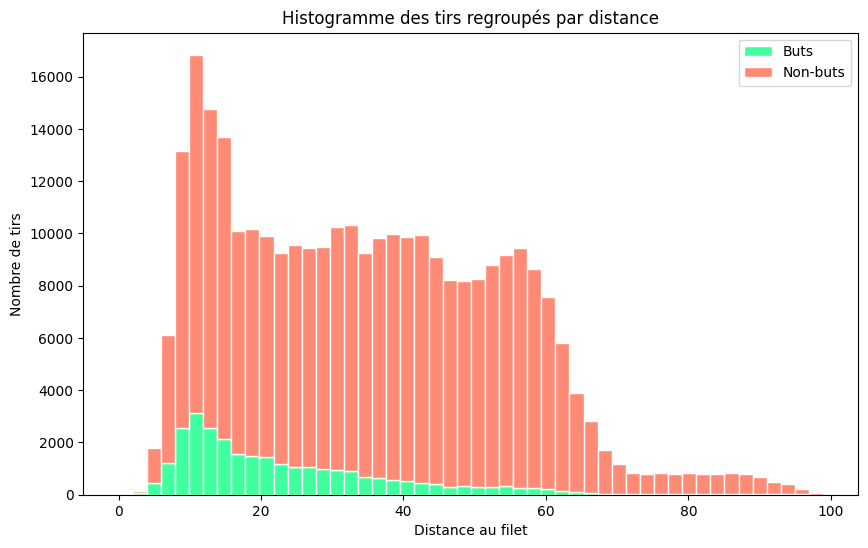

In [6]:
plot_shot_by_distance(df)

### 2) histogramme des tirs regroupés par angle

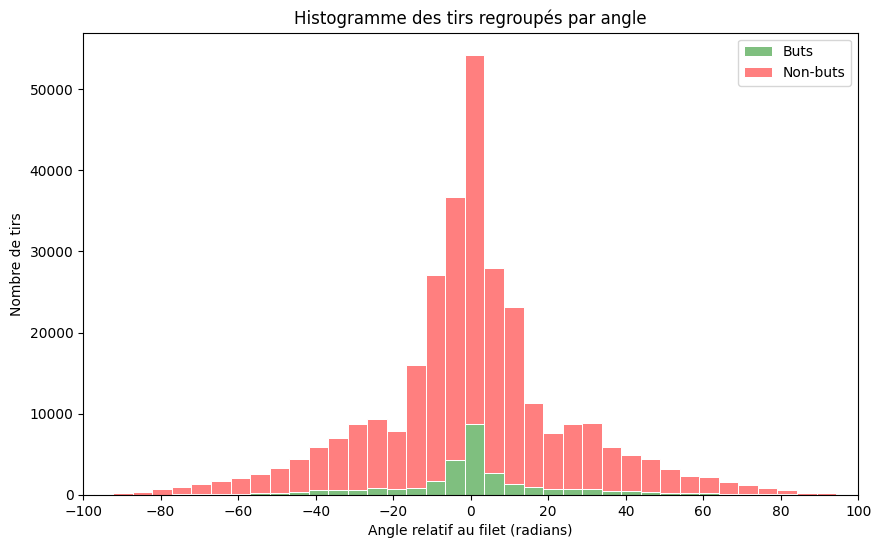

In [7]:
plot_stacked_histogram(df, 'relativeAngleToNet', title="Histogramme des tirs regroupés par angle", xlabel="Angle relatif au filet (radians)", ylabel="Nombre de tirs", legend_labels=['Non-buts', 'Buts'])

### 3) Histogramme 2D de la distance et de l'angle des tirs

<Figure size 1000x800 with 0 Axes>

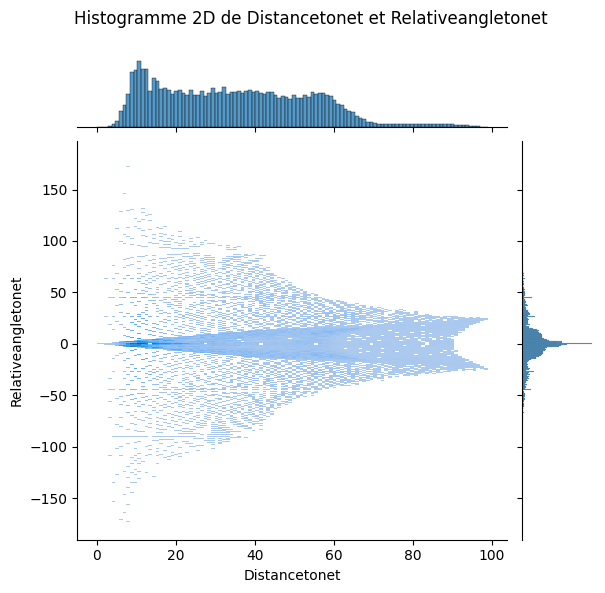

In [8]:
plot_dist_angle(df, "distanceToNet", "relativeAngleToNet")

### 4) Taux de but en fonction de la distance (refaire)

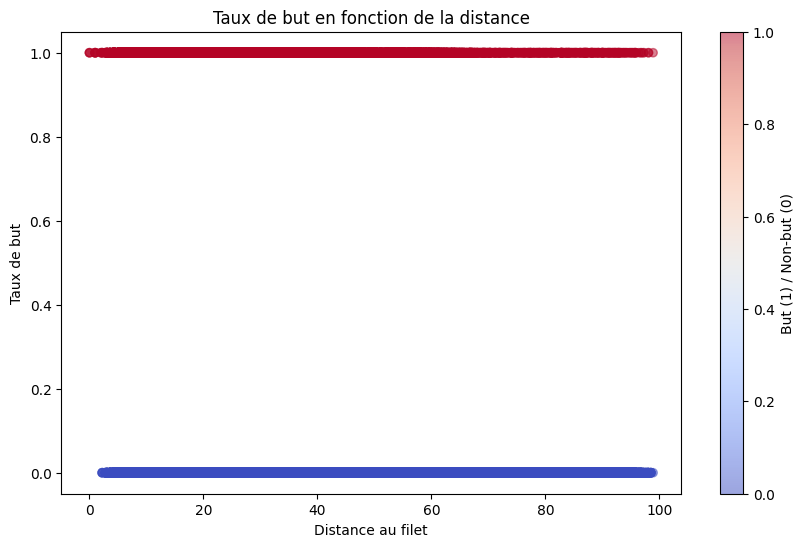

In [9]:
df['but_rate_distance'] = df['isGoal'] / (df['isGoal'] + (1 - df['isGoal']))

# Créer un nuage de points pour visualiser le taux de but en fonction de la distance
plt.figure(figsize=(10, 6))
plt.scatter(df['distanceToNet'], df['but_rate_distance'], alpha=0.5, c=df['isGoal'], cmap='coolwarm')

# Définir des titres et des légendes
plt.title("Taux de but en fonction de la distance")
plt.xlabel("Distance au filet")
plt.ylabel("Taux de but")
plt.colorbar(label="But (1) / Non-but (0)")

# Afficher le nuage de points
plt.show()

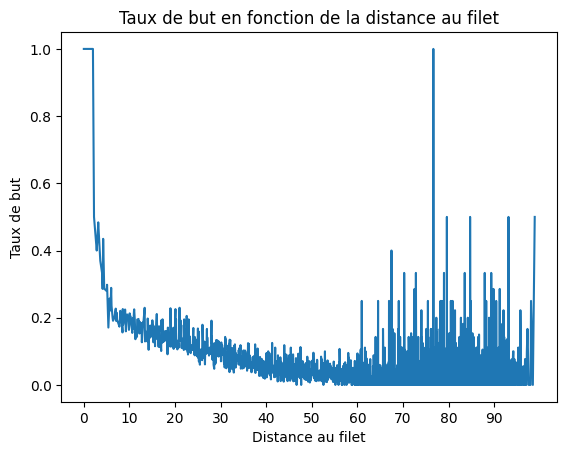

In [10]:
plot_goal_rate_distance(df)

=> Pas ouf il faut changer 

### 5) Histogramme des buts classés par distance filet vide et non vide

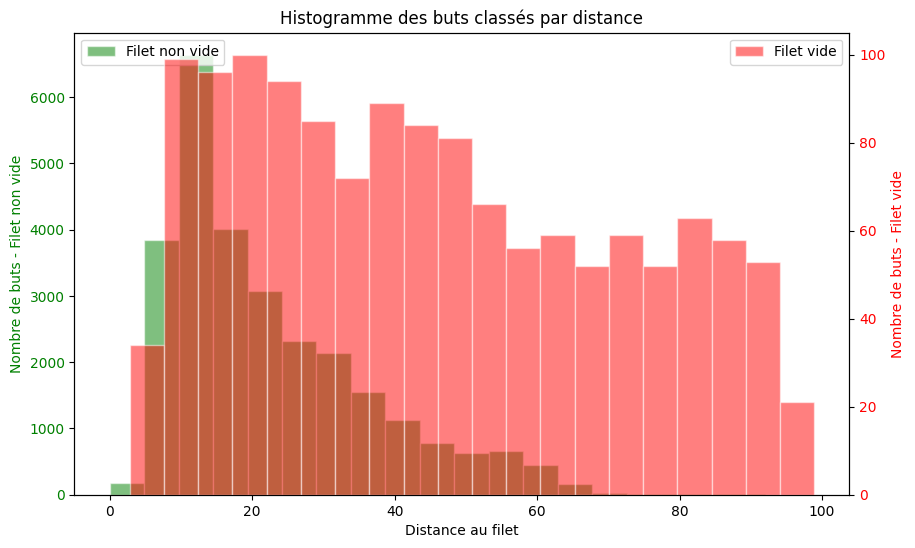

In [11]:
plot_but_distance(df)